## INF8245E (Fall 2021) : Machine Learning - Assignment 1
## Amine EL AMERI - Matricule: 2164634

In [1]:
# this notebook is only tested on jupyter locally, some commands, like those for uploading the datasets may not work
# on colab because of its default working directory which is different than jupyter's

In [2]:
import numpy as np
from numpy.linalg import inv, pinv
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
plt.rcParams['figure.figsize'] = [25, 6]

## 1 Sampling

##### Q2

In [3]:
def multinomial_activities():
    randNumber = np.random.uniform(0,1)

    if 0 <= randNumber < 0.2:
        return "Movies"
    elif 0.2 <= randNumber < 0.6:
        return "INF8245E"
    elif 0.6 <= randNumber < 0.7:
        return "Playing"
    else:
        return "Studying"

In [4]:
def student_routine(nDays):
    fracMovies = 0
    fracINF8245E = 0
    fracPlaying = 0
    fracStudying = 0
    
    for i in range(nDays):
        activity = multinomial_activities()
        if activity == "Movies":
            fracMovies += 1
        elif activity == "INF8245E":
            fracINF8245E += 1
        elif activity == "Playing":
            fracPlaying += 1
        else:
            fracStudying += 1
    return {"fracMovies": fracMovies/nDays, "fracINF8245E": fracINF8245E/nDays, "fracPlaying": fracPlaying/nDays, "fracStudying" :fracStudying/nDays}

In [5]:
print("For 100 days: " + str(student_routine(100)))
print("For 1000 days: " + str(student_routine(1000)))

For 100 days: {'fracMovies': 0.22, 'fracINF8245E': 0.3, 'fracPlaying': 0.11, 'fracStudying': 0.37}
For 1000 days: {'fracMovies': 0.215, 'fracINF8245E': 0.379, 'fracPlaying': 0.102, 'fracStudying': 0.304}


## 2 Model Selection

##### Importing Datasets

In [6]:
myPath = "Datasets/"
from os import listdir
from os.path import isfile, join
files = [(myPath + f) for f in listdir(myPath) if isfile(join(myPath, f))]
files

['Datasets/communities.data',
 'Datasets/communities.names',
 'Datasets/Dataset_1_test.csv',
 'Datasets/Dataset_1_train.csv',
 'Datasets/Dataset_1_valid.csv',
 'Datasets/Dataset_2_test.csv',
 'Datasets/Dataset_2_train.csv',
 'Datasets/Dataset_2_valid.csv',
 'Datasets/README.txt']

##### Q1

###### Q1-a

In [7]:
# reading data
train1 = pd.read_csv('Datasets/Dataset_1_train.csv', header=None, usecols=[0,1])
valid1 = pd.read_csv('Datasets/Dataset_1_valid.csv', header=None, usecols=[0,1])
test1 = pd.read_csv('Datasets/Dataset_1_test.csv', header=None, usecols=[0,1])

X1_examples_train, X1_examples_valid, X1_examples_test = train1[0].tolist(), valid1[0].tolist(), test1[0].tolist()
Y1_train, Y1_valid, Y1_test = train1[1].tolist(), valid1[1].tolist(), test1[1].tolist()
Y1_train, Y1_valid, Y1_test = np.array([Y1_train]).T, np.array([Y1_valid]).T, np.array([Y1_test]).T

In [8]:
# construction of the data matrix X
def construct_data_matrix_X(X_examples): #construction of the matrice X containing

    nbr_examples = len(X_examples)
    X = np.zeros((nbr_examples, 21))

    # 20-degree polynomial in every line
    for i in range(nbr_examples):
        x = X_examples[i]
        X[i,:] = [np.power(x,j) for j in range(21)]
    
    return X

In [9]:
# solving for the parameters using the closed solution of the least square
def fit_20_degree_polynomial_without_regularization(X_data_matrix, Y):
    
    # solving for the parameters
    W = np.matmul(inv(np.matmul(X_data_matrix.T, X_data_matrix)), np.matmul(X_data_matrix.T, Y))
    
    return W

In [10]:
# calculate the root mean square error
def RMSE(X_data_matrix, Y, W):
    nbr_examples = X_data_matrix.shape[0]
    
    # least square error
    E = float(np.matmul((Y - np.matmul(X_data_matrix, W)).T, (Y - np.matmul(X_data_matrix, W)))/2)
    
    #RMSE
    RMSE = np.sqrt((2*E)/nbr_examples)
    
    return RMSE

In [11]:
X1_data_matrix_train = construct_data_matrix_X(X1_examples_train)
X1_data_matrix_valid = construct_data_matrix_X(X1_examples_valid)
X1_data_matrix_test = construct_data_matrix_X(X1_examples_test)

In [12]:
W = fit_20_degree_polynomial_without_regularization(X1_data_matrix_train, Y1_train)

# RMSE for training set
RMSE_train = RMSE(X1_data_matrix_train, Y1_train, W)
print(f"RMSE_train: {RMSE_train}\n")

# RMSE for validation set
RMSE_valid = RMSE(X1_data_matrix_valid, Y1_valid, W)
print(f"RMSE_valid: {RMSE_valid}\n")

RMSE_train: 2.544695842834324

RMSE_valid: 37.666521492377456



###### Q1-b

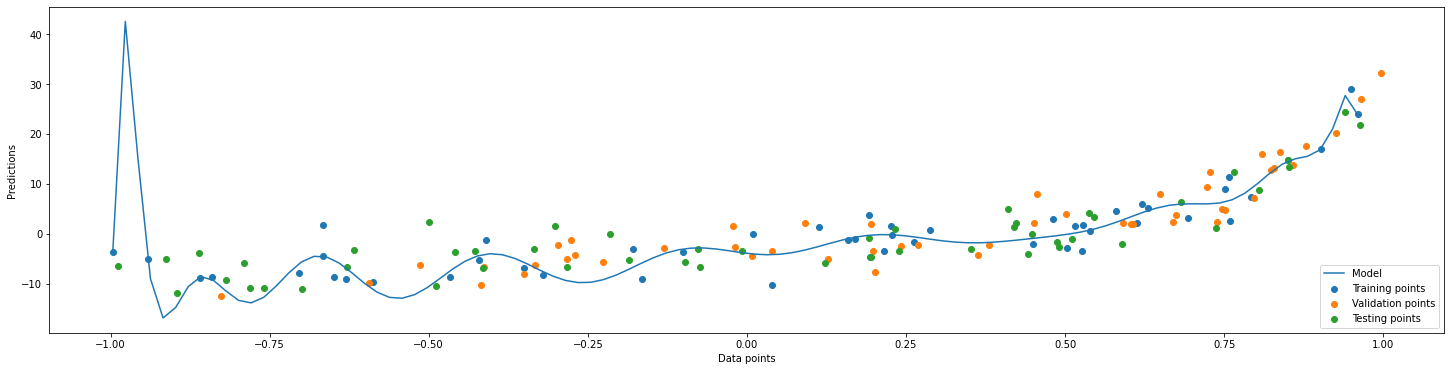

In [13]:
# Plotting the training and the validation points
plt.scatter(X1_examples_train, Y1_train, label="Training points")
plt.scatter(X1_examples_valid, Y1_valid, label="Validation points")
plt.scatter(X1_examples_test, Y1_test, label="Testing points")

# plotting the model on 100 points
model_x = np.linspace(min(X1_examples_train), max(X1_examples_train), 100)
X1_model = construct_data_matrix_X(model_x)
model_y = np.matmul(X1_model, W)

plt.plot(model_x, list(model_y[:,0]), label="Model")
plt.xlabel("Data points")
plt.ylabel("Predictions")
plt.legend(loc='best')
plt.show()

###### Q1-c

The model is overfitting, because 20 degree polynomial is more than what is needed to model the data

##### Q2

###### Q2-a

In [14]:
# solving for the parameters using the closed solution of the least square with L2 regularization
def fit_20_degree_polynomial_L2_regularization(X_data_matrix, Y, lambd):
    
    dim = X_data_matrix.T.shape[0]
    
    # solving for the parameters
    W = np.matmul( inv(np.matmul(X_data_matrix.T, X_data_matrix) + lambd*np.eye(dim)), np.matmul(X_data_matrix.T, Y) )
    
    return W

In [15]:
# calculate the root mean square error
def RMSE_L2_regularization(X_data_matrix, Y, W, lambd):
    nbr_examples = X_data_matrix.shape[0]
    
    # least square error
    E = float(np.matmul((Y - np.matmul(X_data_matrix, W)).T, (Y - np.matmul(X_data_matrix, W))) + lambd*np.matmul(W.T, W))/2
    
    #RMSE
    RMSE = np.sqrt((2*E)/nbr_examples)
    
    return RMSE

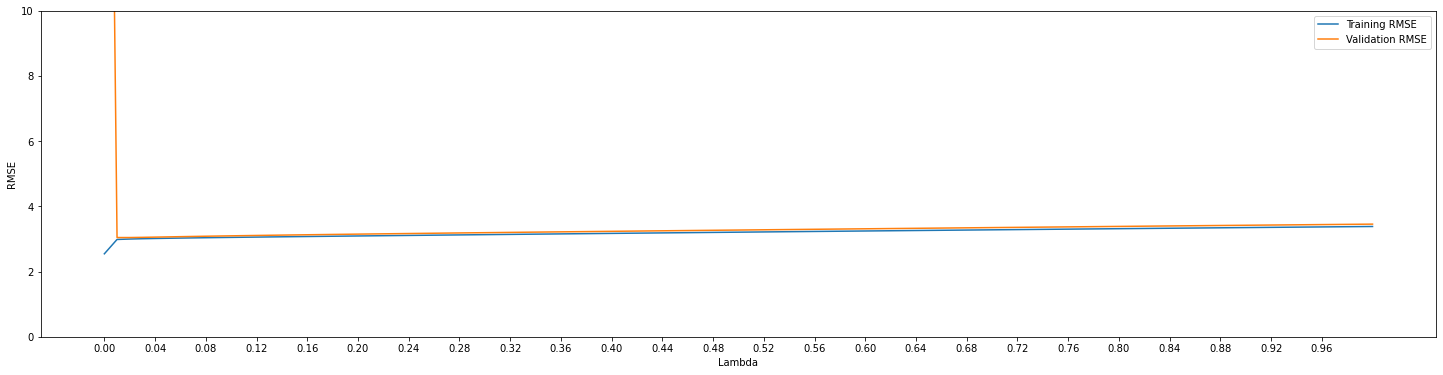

In [16]:
lambds = np.arange(0, 1.01, 0.01)

RMSEs_train = []
RMSEs_valid = []
for lambd in lambds:
    W_L2 = fit_20_degree_polynomial_L2_regularization(X1_data_matrix_train, Y1_train, lambd)

    # RMSE for training set
    RMSE_train_L2 = RMSE_L2_regularization(X1_data_matrix_train, Y1_train, W_L2, lambd)
    RMSEs_train.append(RMSE_train_L2)

    # RMSE for validation set
    RMSE_valid_L2 = RMSE_L2_regularization(X1_data_matrix_valid, Y1_valid, W_L2, lambd)
    RMSEs_valid.append(RMSE_valid_L2)


# Plotting
fig, ax = plt.subplots()
ax.plot(lambds, RMSEs_train, label = "Training RMSE")
ax.plot(lambds, RMSEs_valid, label = "Validation RMSE")

ax.set_xlabel("Lambda")

plt.xticks(np.arange(min(lambds), max(lambds), 0.04))
ax.set_ylabel("RMSE")
ax.set_ylim([0, 10])
ax.legend(loc='best')
plt.show()

###### Q2-b

In [17]:
# the best lambda
best_lambda = lambds[np.argmin(np.array(RMSEs_valid))]
print(f"Best lambda: {best_lambda}")

Best lambda: 0.01


In [18]:
W_L2_best_lambda = fit_20_degree_polynomial_L2_regularization(X1_data_matrix_train, Y1_train, best_lambda)

# RMSE for train set
RMSE_train_L2 = RMSE_L2_regularization(X1_data_matrix_train, Y1_train, W_L2_best_lambda, 0.01)
print(f"RMSE train set (best lambda={best_lambda}): {RMSE_train_L2}\n")

# RMSE for valid set
RMSE_valid_L2 = RMSE_L2_regularization(X1_data_matrix_valid, Y1_valid, W_L2_best_lambda, 0.01)
print(f"RMSE valid set (best lambda={best_lambda}): {RMSE_valid_L2}\n")

# RMSE for test set
RMSE_test_L2 = RMSE_L2_regularization(X1_data_matrix_test, Y1_test, W_L2_best_lambda, 0.01)
print(f"RMSE regul test set (best lambda={best_lambda}): {RMSE_test_L2}\n")


RMSE train set (best lambda=0.01): 2.984477379420454

RMSE valid set (best lambda=0.01): 3.0430680451547643

RMSE regul test set (best lambda=0.01): 3.304821323218764



###### Q2-c

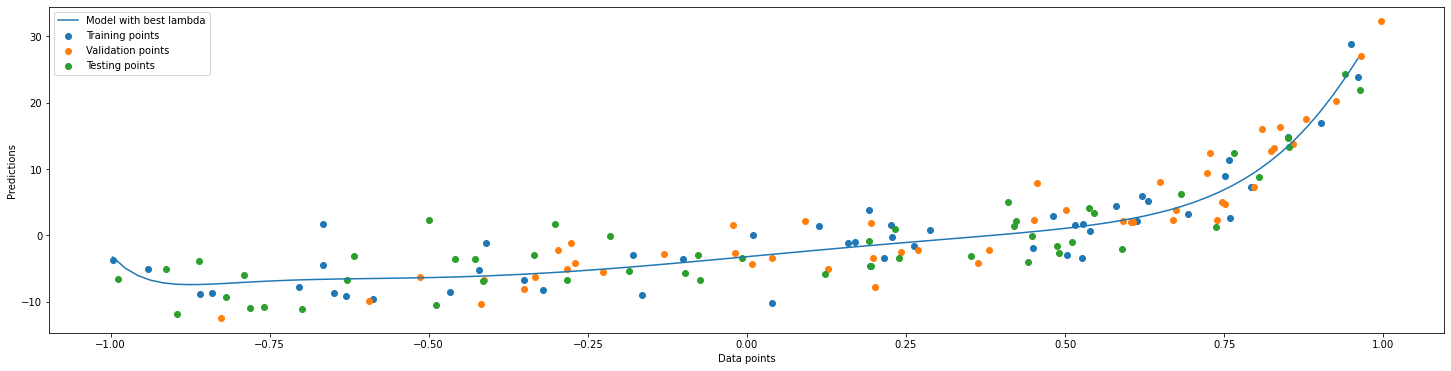

In [19]:
# Plotting the training, the validation and the testing points
plt.scatter(X1_examples_train, Y1_train, label="Training points")
plt.scatter(X1_examples_valid, Y1_valid, label="Validation points")
plt.scatter(X1_examples_test, Y1_test, label="Testing points")

# plotting the model with the best lambda on 100 points
model_x_reg = np.linspace(min(X1_examples_train), max(X1_examples_train), 100)
X1_model_reg = construct_data_matrix_X(model_x)
model_y_reg = np.matmul(X1_model_reg, W_L2_best_lambda)


plt.plot(model_x_reg, list(model_y_reg[:,0]), label="Model with best lambda")
plt.xlabel("Data points")
plt.ylabel("Predictions")
plt.legend(loc='best')
plt.show()

###### Q2-d

The model with the best lambda tends to be a little bit underfitting in regards of the testing data points, but is in general fitting the training and validation data very good

##### Q3

When looking at the shape of model obtained with the best lambda, I think the degree of the source polynomial is 2, because we can have a very close looking model with 2nd degree polynomial.

## 3 Gradient Descent for Regression

In [20]:
# reading data
train2 = pd.read_csv('Datasets/Dataset_2_train.csv', header=None, usecols=[0,1])
valid2 = pd.read_csv('Datasets/Dataset_2_valid.csv', header=None, usecols=[0,1])
test2 = pd.read_csv('Datasets/Dataset_2_test.csv', header=None, usecols=[0,1])

X2_examples_train, X2_examples_valid, X2_examples_test = train2[0].tolist(), valid2[0].tolist(), test2[0].tolist()
Y2_train, Y2_valid, Y2_test = train2[1].tolist(), valid2[1].tolist(), test2[1].tolist()
Y2_train, Y2_valid, Y2_test = np.array([Y2_train]).T, np.array([Y2_valid]).T, np.array([Y2_test]).T

##### Q1

##### Q1-a

In [21]:
def calculate_Loss(X_data_points, Y, w0, w1):
    return np.sum( ((w0 + w1*np.array(X_data_points)) - np.array(Y)) **2)/(2*len(X_data_points))
    
def SGD(X_train_data_points, Y_train, X_valid_data_points, Y_valid, alpha, k):
    
    nDataPoints = len(X_train_data_points)
    
    w0 = np.random.uniform(0, 0.1, 1)[0]
    w1 = np.random.uniform(0, 0.1, 1)[0]
    
    nEpochs = 0
    W = []
    trainingLoss = []
    validationLoss = []
    isSameLoss = []
    patience = 0
    done = False
    
    while done == False:
    
        # Shuffle
        X_train_valid = list(zip(X_train_data_points, Y_train))
        np.random.shuffle(X_train_valid)
        x_train, y_train = zip(*X_train_valid)
        
        # update w0 and w1
        for dataPt in range(nDataPoints):
            y_predicted = w0 + w1 * x_train[dataPt]
            y = y_train[dataPt]
            w0 = w0 - alpha * (y_predicted - y)
            w1 = w1 - alpha * (y_predicted - y) * x_train[dataPt]
        
        nEpochs += 1   
        W.append((w0, w1))
        trainingLoss.append(calculate_Loss(X_train_data_points, Y_train, w0, w1))
        validationLoss.append(calculate_Loss(X_valid_data_points, Y_valid, w0, w1))
        
        
        # early stopping
        if (len(validationLoss) > 2) and (validationLoss[nEpochs - 1] >= validationLoss[nEpochs - 2]) :
            patience += 1
            if patience == k:
                done = True
        else:
            patience = 0
        
        # if it diverge
        if nEpochs > 5000:
            done = True
        
    RMSE_train = np.sqrt((2/len(X_train_data_points))*np.array(trainingLoss))
    RMSE_valid = np.sqrt((2/len(X_valid_data_points))*np.array(validationLoss))
    return (RMSE_train, RMSE_valid, nEpochs, W)

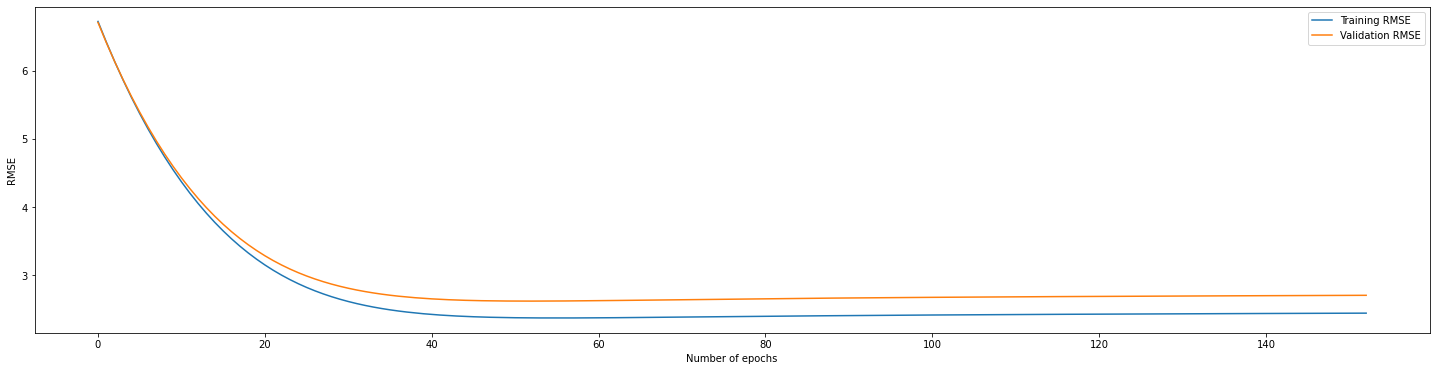

In [22]:
(RMSEs_train2, RMSEs_valid2, nEpochs, W) = SGD(X2_examples_train, Y2_train, X2_examples_valid, Y2_valid, 1e-4, 100)
plt.plot(np.arange(nEpochs), RMSEs_train2, label = "Training RMSE")
plt.plot(np.arange(nEpochs), RMSEs_valid2, label = "Validation RMSE")
plt.xlabel("Number of epochs")
plt.ylabel("RMSE")
plt.legend(loc='best')
plt.show()

##### Q2

##### Q2-a

In [23]:
stepSizes = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
validationPerformances = []
for stepsize in stepSizes:
    RMSEs_train2, RMSEs_valid2, nEpochs, W = SGD(X2_examples_train, Y2_train, X2_examples_valid, Y2_valid, stepsize, 100)
    validationPerformances.append(RMSEs_valid2[-1])

print(f"Step sizes: {stepSizes}")
print(f"Validation RMSE: {validationPerformances}")

Step sizes: [0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07]
Validation RMSE: [2.8376910370448316, 2.8300459914198184, 2.6925712772639177, 2.6195388560814035, 2.614748575679913, 5.617836542979559]


In [24]:
best_stepsize = stepSizes[np.argmin(validationPerformances)]
print(f"The best stepzise : {best_stepsize}")

The best stepzise : 1e-06


##### Q2-b

In [25]:
_, _, nEpochs, W = SGD(X2_examples_train, Y2_train, X2_examples_valid, Y2_valid, best_stepsize, 100)
test_loss2 = calculate_Loss(X2_examples_test, Y2_test, W[-1][0][0], W[-1][1][0])
RMSE_test2 = np.sqrt((2*test_loss2)/len(X2_examples_test))
print(f"RMSE of the chosen model with the best stepsize: {RMSE_test2}")

RMSE of the chosen model with the best stepsize: 2.4727560808447806


##### Q3

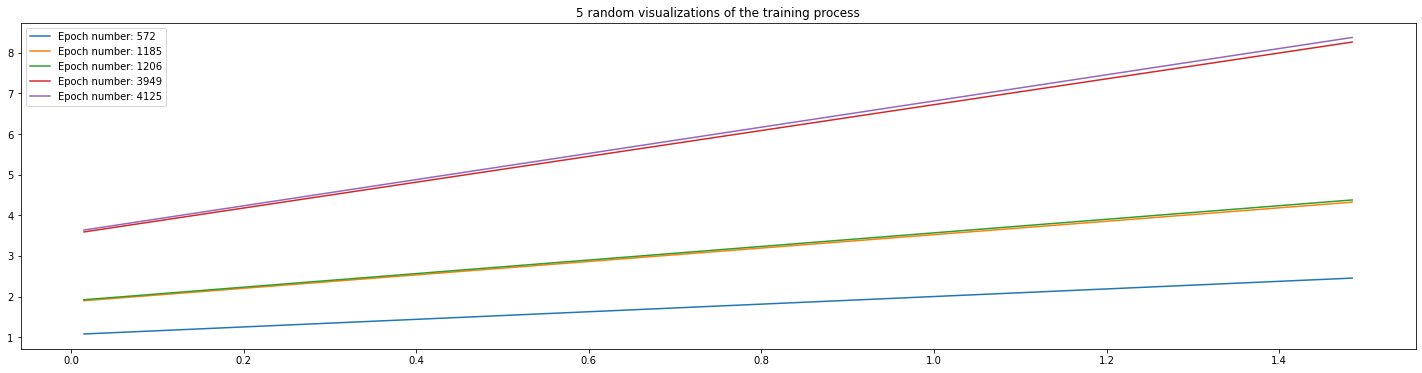

In [26]:
fiveRandomNumbers = np.sort(np.random.randint(nEpochs, size=5))

x = np.linspace(min(X2_examples_train), max(X2_examples_train), 100)

fig, ax = plt.subplots()
for i in fiveRandomNumbers:
    lbl = "Epoch number: " + str(i)
    ax.plot(x, W[i][0][0] + W[i][1][0]*x, label = lbl)
    
ax.set_title("5 random visualizations of the training process")
plt.legend(loc='best')
plt.show()
    

##### Q4

In [27]:
def calculate_Loss_derivative_w0(X_data_points, Y, w0, w1):
    return np.sum( ((w0 + w1*np.array(X_data_points)) - np.array(Y)))/len(X_data_points)

def calculate_Loss_derivative_w1(X_data_points, Y, w0, w1):
    return np.sum( ((w0 + w1*np.array(X_data_points)) - np.array(Y))*np.array(X_data_points) )/len(X_data_points)

def fullBatchGD(X_train_data_points, Y_train, X_valid_data_points, Y_valid):
    alpha = 1e-4
    
    w0 = np.random.uniform(0, 0.1, 1)[0]
    w1 = np.random.uniform(0, 0.1, 1)[0]
    
    nIterations = 0
    W = []
    trainingLoss = []
    validationLoss = []
    done = False
    
    while done == False:
        
        # update w0 and w1
            
        loss_w1_tmp = calculate_Loss_derivative_w1(X_train_data_points, Y_train, w0, w1) #not to use new w0 in w1 update
        w0 = w0 - alpha * calculate_Loss_derivative_w0(X_train_data_points, Y_train, w0, w1)
        w1 = w1 - alpha * loss_w1_tmp
        
        nIterations += 1   
        W.append((w0, w1))
        trainingLoss.append(calculate_Loss(X_train_data_points, Y_train, w0, w1))
        validationLoss.append(calculate_Loss(X_valid_data_points, Y_valid, w0, w1))
        
        
        # Stopping condition
        if (len(validationLoss) > 2) and abs(validationLoss[nIterations-1] - validationLoss[nIterations-2]) <= 1e-4 :
            done = True
        
        # if it diverge
        if nIterations > 5000:
            done = True
        
    RMSE_train = np.sqrt((2/len(X_train_data_points))*np.array(trainingLoss))
    RMSE_valid = np.sqrt((2/len(X_valid_data_points))*np.array(validationLoss))
    return (RMSE_train, RMSE_valid, nIterations, W)

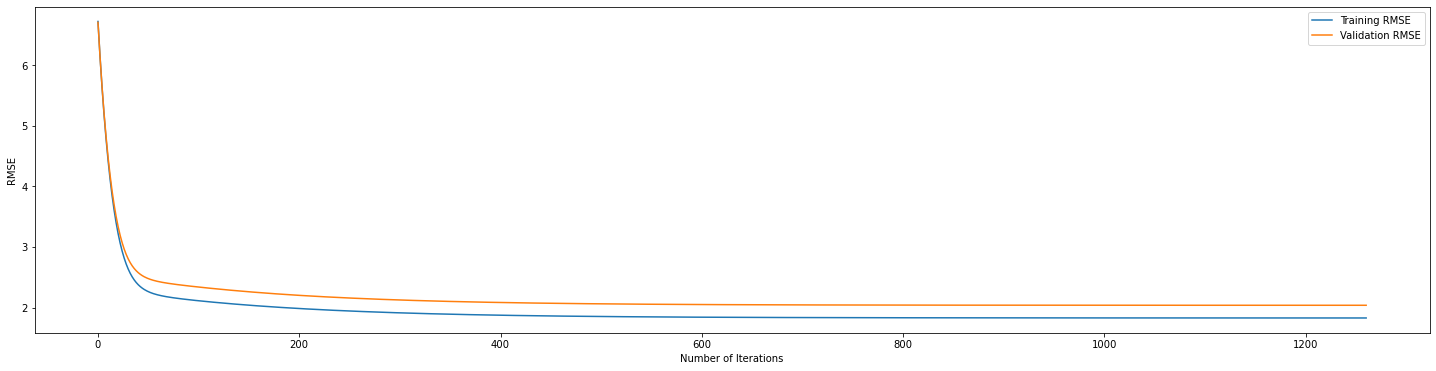

In [28]:
(RMSEs_train2_FBGD, RMSEs_valid2_FBGD, nIterations, W_FBGD) = fullBatchGD(X2_examples_train, Y2_train, X2_examples_valid, Y2_valid)
plt.plot(np.arange(nIterations), RMSEs_train2_FBGD, label = "Training RMSE")
plt.plot(np.arange(nIterations), RMSEs_valid2_FBGD, label = "Validation RMSE")
plt.xlabel("Number of Iterations")
plt.ylabel("RMSE")
plt.legend(loc='best')
plt.show()

Stochastic GD vs full batch GD: in the report.

## 4 Real life dataset

##### Q1

##### Q1-a

In [29]:
# reading data
df = pd.read_csv('Datasets/communities.data', header=None, na_values='NaN')
df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,?,?,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,?,?,?,?,0.00,?,0.09
1990,6,?,?,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,?,?,?,?,0.00,?,0.45
1991,9,9,80070,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0,0.91,0.28,0.23
1992,25,17,72600,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0,0.22,0.18,0.19


In [30]:
for i in range(df.shape[1]):
    
    df[i].replace('?', np.nan, inplace=True)
    
    #if its a column of numbers
    if df[i][df[i].astype(str).str.isnumeric() == True].empty == False:
        
        #change NaN values by the mean in each column
        df[i] = pd.to_numeric(df[i])
        df[i].fillna(df[i].mean(skipna=True), inplace=True)

Filling the missing attributes with the mean is not a good choice because the mean is not robust to outliers (very big numbers for example), and also because it can have no meaning if the numerical data is discrete (for example if our data is a list of country calling codes).

##### Q1-b

We can use the median of each column instead of the mean to fill the missing attributes.

##### Q1-c

The median is better than the mean because it is robust to outliers like very big and very small numbers

In [31]:
df = pd.read_csv('Datasets/communities.data', header=None, na_values='NaN')

for i in range(df.shape[1]):
    
    df[i].replace('?', np.nan, inplace=True)
    
    #if its a column of numbers
    if df[i][df[i].astype(str).str.isnumeric() == True].empty == False:
        
        #change NaN values by the median in each column
        df[i] = pd.to_numeric(df[i])
        df[i].fillna(df[i].median(skipna=True), inplace=True)

##### Q1-d

In [32]:
df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,8,23.0,48090.0,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.90,0.5,0.32,0.14,0.20
1,53,23.0,48090.0,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,0.08,0.03,0.75,0.5,0.00,0.15,0.67
2,24,23.0,48090.0,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,0.08,0.03,0.75,0.5,0.00,0.15,0.43
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,0.08,0.03,0.75,0.5,0.00,0.15,0.12
4,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,0.08,0.03,0.75,0.5,0.00,0.15,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,23.0,48090.0,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,0.08,0.03,0.75,0.5,0.00,0.15,0.09
1990,6,23.0,48090.0,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,0.08,0.03,0.75,0.5,0.00,0.15,0.45
1991,9,9.0,80070.0,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0.0,0.91,0.28,0.23
1992,25,17.0,72600.0,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0.0,0.22,0.18,0.19


##### Q2

##### Q2-a

In [33]:
twentyPercent = int((20*df.shape[0])/100)
eightyPercent = int((80*df.shape[0])/100)

df_test = df[:][0: twentyPercent].copy()
df_train = df[:][twentyPercent: twentyPercent + eightyPercent+1].copy()

for i in range(df.shape[1]):
    
    #if its a column of strings, drop it
    if (str(df[i][0]) == df[i][0]):
        del df_test[i]
        del df_train[i]

In [34]:
oneFifth = int((20*df_train.shape[0])/100)

fold1 = df_train[:][0: oneFifth].copy()
fold2 = df_train[:][oneFifth: 2*oneFifth].copy()
fold3 = df_train[:][2*oneFifth: 3*oneFifth].copy()
fold4 = df_train[:][3*oneFifth: 4*oneFifth].copy()
fold5 = df_train[:][4*oneFifth: 5*oneFifth].copy()

combis = []
# tuples of the form (4 training folds, validation fold)
combis.append ( ([fold2, fold3, fold4, fold5], fold1) )
combis.append ( ([fold1, fold3, fold4, fold5], fold2) )
combis.append ( ([fold1, fold2, fold4, fold5], fold3) )
combis.append ( ([fold1, fold2, fold3, fold5], fold4) )
combis.append ( ([fold1, fold2, fold3, fold4], fold5) )

In [35]:
RMSEs_Q4_valid = []
RMSEs_Q4_test = []
for combination in combis:
    
    # training data
    X_Q4_train = np.concatenate((combination[0][0].to_numpy(), combination[0][1].to_numpy(), combination[0][2].to_numpy(), combination[0][3]), axis = 0)
    Y_Q4_train = X_Q4_train[:, 126]
    X_Q4_train = np.delete(X_Q4_train, 126, 1)
    
    # solving for the parameters W using closed solution
    W_Q4 = np.matmul(inv(np.matmul(X_Q4_train.T, X_Q4_train)), np.matmul(X_Q4_train.T, Y_Q4_train))
    
    #validation data
    X_Q4_valid = combination[1].to_numpy()
    Y_Q4_valid = X_Q4_valid[:, 126]
    X_Q4_valid = np.delete(X_Q4_valid, 126, 1)
    
    #testing data
    X_Q4_test = df_test.to_numpy()
    Y_Q4_test = X_Q4_test[:, 126]
    X_Q4_test = np.delete(X_Q4_test, 126, 1)
    
    # least square error (validation)
    E_Q4_valid = float(np.matmul((Y_Q4_valid - np.matmul(X_Q4_valid, W_Q4)).T, (Y_Q4_valid - np.matmul(X_Q4_valid, W_Q4)))/2)
    
    # least square error (test)
    E_Q4_test = float(np.matmul((Y_Q4_test - np.matmul(X_Q4_test, W_Q4)).T, (Y_Q4_test - np.matmul(X_Q4_test, W_Q4)))/2)
    
    #RMSE validation
    RMSEs_Q4_valid.append(np.sqrt((2*E_Q4_valid)/X_Q4_valid.shape[0]))
    
    #RMSE test
    RMSEs_Q4_test.append(np.sqrt((2*E_Q4_test)/X_Q4_test.shape[0]))
    
print(f"5-fold cross-validation average RMSE: {np.mean(RMSEs_Q4_valid)}")
    

5-fold cross-validation average RMSE: 7.16285010171427


##### Q2-b

In [36]:
print(f"test RMSEs for each of the 5-fold cross-validation : {RMSEs_Q4_test}\n")
print(f"Average test RMSE: {np.mean(RMSEs_Q4_test)}")

test RMSEs for each of the 5-fold cross-validation : [0.13985036367995404, 0.14100284704622496, 0.14119868621564738, 34.935128521756695, 0.14129304225951544]

Average test RMSE: 7.099694692191607


##### Q3

##### Q3-a

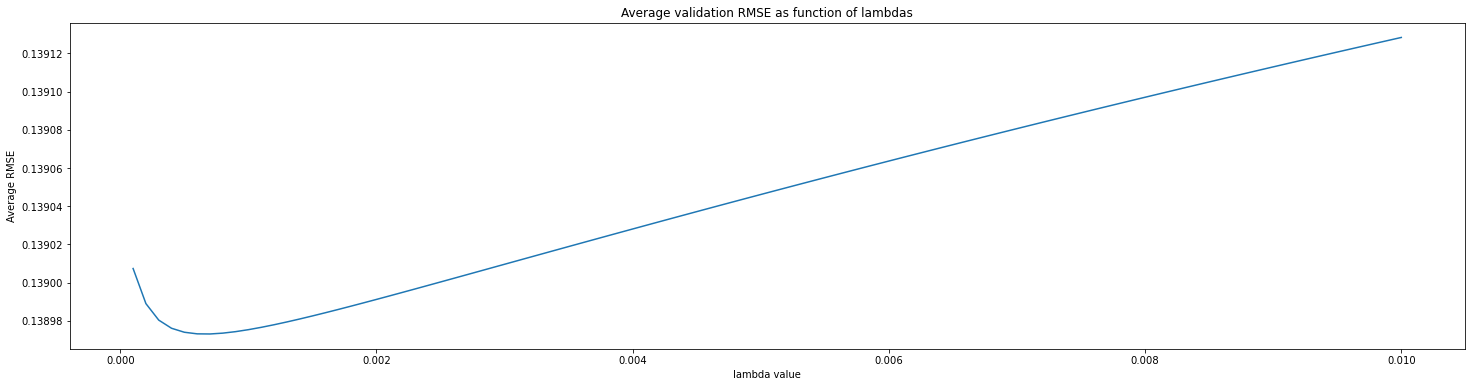

In [37]:
lambdasQ4 = np.linspace(0.0001, 0.01, 100)


RMSE_for_lambda_valid = []
RMSE_for_lambda_test = []
Ws_Q4 = []
for lambd in lambdasQ4:
    RMSEs_Q4_valid_reg = []
    RMSEs_Q4_test_reg = []
    for combination in combis:

        dim = X_Q4_train.T.shape[0]
        # training data
        X_Q4_train = np.concatenate((combination[0][0].to_numpy(), combination[0][1].to_numpy(), combination[0][2].to_numpy(), combination[0][3]), axis = 0)
        Y_Q4_train = X_Q4_train[:, 126]
        X_Q4_train = np.delete(X_Q4_train, 126, 1)

        # solving for the parameters W using closed solution and regularization
        W_Q4 = np.matmul( inv(np.matmul(X_Q4_train.T, X_Q4_train) + lambd*np.eye(dim) ), np.matmul(X_Q4_train.T, Y_Q4_train))


        #validation data
        X_Q4_valid = combination[1].to_numpy()
        Y_Q4_valid = X_Q4_valid[:, 126]
        X_Q4_valid = np.delete(X_Q4_valid, 126, 1)

        #testing data
        X_Q4_test = df_test.to_numpy()
        Y_Q4_test = X_Q4_test[:, 126]
        X_Q4_test = np.delete(X_Q4_test, 126, 1)

        # least square error (validation) with regularization
        E_Q4_valid = float(np.matmul((Y_Q4_valid - np.matmul(X_Q4_valid, W_Q4)).T, (Y_Q4_valid - np.matmul(X_Q4_valid, W_Q4))) + lambd*np.matmul(W_Q4.T, W_Q4))/2

        # least square error (test) with regularization
        E_Q4_test = float(np.matmul((Y_Q4_test - np.matmul(X_Q4_test, W_Q4)).T, (Y_Q4_test - np.matmul(X_Q4_test, W_Q4))) + lambd*np.matmul(W_Q4.T, W_Q4))/2


        #RMSE validation
        RMSEs_Q4_valid_reg.append(np.sqrt((2*E_Q4_valid)/X_Q4_valid.shape[0]))

        #RMSE test
        RMSEs_Q4_test_reg.append(np.sqrt((2*E_Q4_test)/X_Q4_test.shape[0]))
        
    RMSE_for_lambda_valid.append(np.mean(RMSEs_Q4_valid_reg))
    RMSE_for_lambda_test.append(np.mean(RMSEs_Q4_test_reg))
    Ws_Q4.append(W_Q4)
    
plt.plot(lambdasQ4, RMSE_for_lambda_valid)
plt.xlabel("lambda value")
plt.ylabel("Average RMSE")
plt.title("Average validation RMSE as function of lambdas")
plt.show()

If lambda = 0 then it's like if there is no regularization at all, so we'll explore values > 0, and we know that lambda is the penalty term that tries to force some coefficients to be close to 0 so that there is no overfitting, but because of this, if we take a big lambda then we'll end up forcing too many coefficients to be close to zero and so our model will be underfitting.
I started by trying numbers in the uniform interval [0, 20], and found that once lambda > 1 the RMSE only becomes larger, so changed to [0, 1] and same thing happened once lambda > 0.1, so after some iterations found the interval [0.0001, 0.01] and this time the RMSE decreased to arrive at its minimum at lambda = 0.0006 then started increasing.

##### Q3-b

Lambda = 0.0006 gives the best fit

##### Q3-c

In [38]:
print(f"Test RMSE using lambda = {lambdasQ4[5]}, is : {RMSE_for_lambda_test[5]}")

Test RMSE using lambda = 0.0006000000000000001, is : 0.14106292723223307


##### Q3-d

We can take the parameters learned from the training with regularization, and see which ones are the smallest (the closest to zero), these are the ones that has been reduced due to the regularization, because they correspond to features that are not very important in the prediction task, and so we can drop these features.

In [39]:
# we only take features whose learned parameter is greater than 1e-1
reduced_features = np.array([i for i in range(len(Ws_Q4[5])) if ((abs(Ws_Q4[5])>1e-1)[i] == True)])
reduced_features

array([  6,  10,  11,  12,  14,  16,  17,  19,  20,  22,  23,  25,  31,
        32,  35,  37,  40,  41,  42,  43,  45,  46,  48,  52,  53,  54,
        62,  63,  64,  65,  66,  67,  68,  70,  71,  72,  75,  77,  83,
        84,  87,  89,  93,  94,  95, 100, 101, 102, 103, 104, 105, 106,
       107, 109, 110, 111, 112, 113, 114, 120, 121, 125])

##### Q3-e

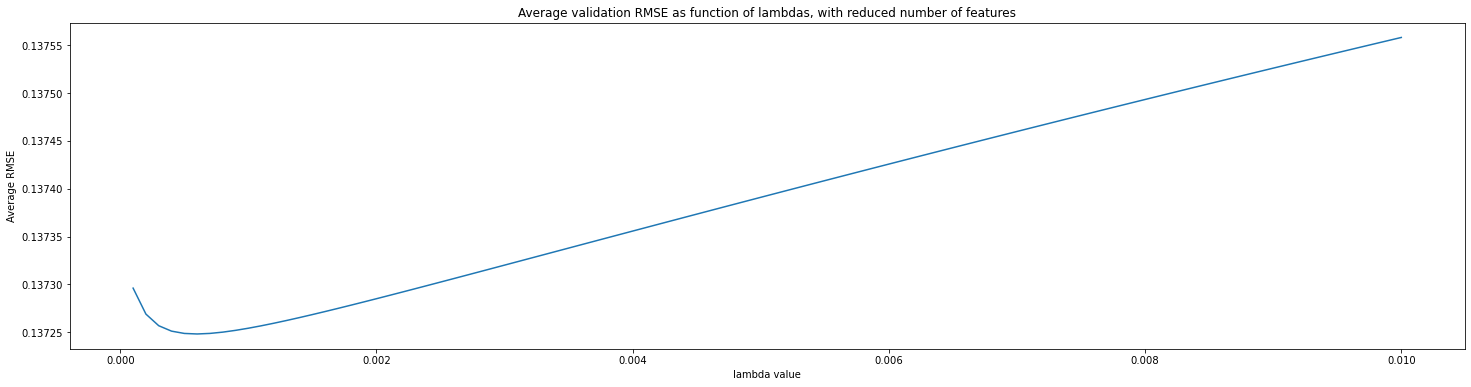

In [40]:
lambdasQ4 = np.linspace(0.0001, 0.01, 100)


RMSE_for_lambda_valid = []
RMSE_for_lambda_test = []
Ws_Q4 = []
for lambd in lambdasQ4:
    RMSEs_Q4_valid_reg = []
    RMSEs_Q4_test_reg = []
    for combination in combis:


        # training data
        X_Q4_train = np.concatenate((combination[0][0].to_numpy(), combination[0][1].to_numpy(), combination[0][2].to_numpy(), combination[0][3]), axis = 0)
        Y_Q4_train = X_Q4_train[:, 126]
        X_Q4_train = np.delete(X_Q4_train, 126, 1)
        
        X_Q4_train = X_Q4_train[:, reduced_features]
        dim = X_Q4_train.T.shape[0]

        # solving for the parameters W using closed solution and regularization
        W_Q4 = np.matmul( inv(np.matmul(X_Q4_train.T, X_Q4_train) + lambd*np.eye(dim) ), np.matmul(X_Q4_train.T, Y_Q4_train))


        #validation data
        X_Q4_valid = combination[1].to_numpy()
        Y_Q4_valid = X_Q4_valid[:, 126]
        X_Q4_valid = np.delete(X_Q4_valid, 126, 1)
        
        X_Q4_valid = X_Q4_valid[:, reduced_features]

        #testing data
        X_Q4_test = df_test.to_numpy()
        Y_Q4_test = X_Q4_test[:, 126]
        X_Q4_test = np.delete(X_Q4_test, 126, 1)
        
        X_Q4_test = X_Q4_test[:, reduced_features]

        # least square error (validation) with regularization
        E_Q4_valid = float(np.matmul((Y_Q4_valid - np.matmul(X_Q4_valid, W_Q4)).T, (Y_Q4_valid - np.matmul(X_Q4_valid, W_Q4))) + lambd*np.matmul(W_Q4.T, W_Q4))/2

        # least square error (test) with regularization
        E_Q4_test = float(np.matmul((Y_Q4_test - np.matmul(X_Q4_test, W_Q4)).T, (Y_Q4_test - np.matmul(X_Q4_test, W_Q4))) + lambd*np.matmul(W_Q4.T, W_Q4))/2


        #RMSE validation
        RMSEs_Q4_valid_reg.append(np.sqrt((2*E_Q4_valid)/X_Q4_valid.shape[0]))

        #RMSE test
        RMSEs_Q4_test_reg.append(np.sqrt((2*E_Q4_test)/X_Q4_test.shape[0]))
        
    RMSE_for_lambda_valid.append(np.mean(RMSEs_Q4_valid_reg))
    RMSE_for_lambda_test.append(np.mean(RMSEs_Q4_test_reg))
    Ws_Q4.append(W_Q4)
    
plt.plot(lambdasQ4, RMSE_for_lambda_valid)
plt.xlabel("lambda value")
plt.ylabel("Average RMSE")
plt.title("Average validation RMSE as function of lambdas, with reduced number of features")
plt.show()

In [41]:
best_lambda = 0.0006

RMSEs_Q4_test_reg = []
for combination in combis:

    
    # training data
    X_Q4_train = np.concatenate((combination[0][0].to_numpy(), combination[0][1].to_numpy(), combination[0][2].to_numpy(), combination[0][3]), axis = 0)
    Y_Q4_train = X_Q4_train[:, 126]
    X_Q4_train = np.delete(X_Q4_train, 126, 1)
    
    X_Q4_train = X_Q4_train[:, reduced_features]
    dim = X_Q4_train.T.shape[0]

    # solving for the parameters W using closed solution and regularization
    W_Q4 = np.matmul( inv(np.matmul(X_Q4_train.T, X_Q4_train) + best_lambda*np.eye(dim) ), np.matmul(X_Q4_train.T, Y_Q4_train))

    #testing data
    X_Q4_test = df_test.to_numpy()
    Y_Q4_test = X_Q4_test[:, 126]
    X_Q4_test = np.delete(X_Q4_test, 126, 1)
    
    X_Q4_test = X_Q4_test[:, reduced_features]

    # least square error (test) with regularization
    E_Q4_test = float(np.matmul((Y_Q4_test - np.matmul(X_Q4_test, W_Q4)).T, (Y_Q4_test - np.matmul(X_Q4_test, W_Q4))) + best_lambda*np.matmul(W_Q4.T, W_Q4))/2


    #RMSE test
    RMSEs_Q4_test_reg.append(np.sqrt((2*E_Q4_test)/X_Q4_test.shape[0]))
        
print(f"test RMSE best fit with reduced number of features: {np.mean(RMSEs_Q4_test_reg)}")



test RMSE best fit with reduced number of features: 0.14233290979224514


##### Q3-f

The test RMSE of the model with all features is 0.14106 while for the model with reduced number of features it is 0.14233, and this even though we have retained only 62 from the 127 features. So we can say that even if the RMSE with reduced feature is slighty bigger than the one with all features, the temporal and spatial complexity that has been reduced is worth it, and also that a lot of features didn't have much importance in our prediction task.